# Linear Regression Models



# PART 1: Linear Regression for Crash Data
We will use the same approach as the violation data, looking only at outside influences and see if we can model the number of daily intersection crashes in Chicago

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from modules.myfuncs import *
import warnings
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100

In [2]:
def cross_val(model, X, y):
    # return a cross val score for my models
    pred = cross_val_score(model, X, y, cv=5)
    return pred.mean()

def print_evaluate(true, predicted):  
    # print out all of my stats for the model
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    # get multiple stats on my model predictions
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [3]:
conn = create_connection('database/rlc.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc.db


In [4]:
print(sql_fetch_tables(c, conn))



def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t-' + col)
        print()

table_info(c, conn)


[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('all_hours',), ('int_startend',), ('intersection_chars',), ('signal_crashes',), ('rlc_all_hours',), ('daily_covid',), ('holidays',)]
cam_locations
	-camera_id
	-intersection
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

cam_startend
	-camera_id
	-start
	-end

daily_violations
	-intersection
	-camera_id
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

all_crashes
	-crash_record_id
	-rd_no
	-crash_date
	-posted_speed_limit
	-traffic_control_device
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-beat_o

In [19]:
# Try to add in rlc_state to a very big already query
crash_df = pd.read_sql_query('''
WITH 
ah AS (SELECT MAX(rlc_state) as rlc_state,
            year,
            month,
            day,
            intersection
    FROM rlc_all_hours 
    GROUP BY year, month, day, intersection),

v AS (SELECT intersection,
            SUM(violations) AS violations,
            month,
            day,
            year,
            violation_date
    FROM daily_violations
    GROUP BY year, month, day, intersection
    ),

cr AS(SELECT year,
             month,
             day,
             COUNT(crash_record_id) AS n_crash,
             SUM(injuries_total) as injuries_total,
             SUM(injuries_fatal) as injuries_fatal

     FROM signal_crashes
     GROUP BY year, month, day
    ),

ic AS
    (SELECT region_id,
            intersection
     FROM intersection_cams
    ),



c AS
    (
        WITH allcg as 
             (SELECT AVG(speed) as speed,
                     AVG(quantile_speed) as quantile_speed,
                     100-AVG(quantile_speed) as avg_congestion,
                     MIN(speed) as min_speed,
                    region_id,
                    month,
                    day,
                    weekday,
                    year
             FROM hourly_congestion
             GROUP BY year, month, day, region_id
            ),

            rh1 as 
             (SELECT 
                    AVG(speed) as morning_rush_speed,
                    MIN(quantile_speed) as morning_rush_quant,
                    100 - MIN(quantile_speed) as morning_rush_congestion,
                    region_id,
                    month,
                    day,
                    weekday,
                    year
             FROM hourly_congestion
             WHERE hour > 5 AND hour < 10
             GROUP BY year, month, day, region_id
            ),

            rh2 as 
             (SELECT MIN(speed) as afternoon_rush_speed,
                    MIN(quantile_speed) as afternoon_rush_quant,
                    100 - MIN(quantile_speed) as afternoon_rush_congestion,
                    region_id,
                    month,
                    day,
                    year
             FROM hourly_congestion
             WHERE hour > 16 AND hour < 20
             GROUP BY year, month, day, region_id
            )

    SELECT allcg.speed,
           allcg.min_speed,
           allcg.region_id,
            allcg.month,
            allcg.day,
            allcg.weekday,
            allcg.year,
            allcg.quantile_speed,
            allcg.avg_congestion,

            rh1.morning_rush_speed,
            rh1.morning_rush_quant,
            rh1.morning_rush_congestion,

            rh2.afternoon_rush_speed,
            rh2.afternoon_rush_quant,
            rh2.afternoon_rush_congestion

     FROM allcg
     LEFT JOIN rh1
         ON rh1.year = allcg.year
         AND rh1.month = allcg.month
         AND rh1.day = allcg.day
         AND rh1.region_id = allcg.region_id
     LEFT JOIN rh2
         ON rh2.year = allcg.year
         AND rh2.month = allcg.month
         AND rh2.day = allcg.day
         AND rh2.region_id = allcg.region_id

     ORDER BY allcg.year, allcg.month, allcg.day, allcg.region_id
),


 wx as
    (SELECT MAX(temp) as temp,
            SUM(snow_1h)+SUM(rain_1h) as precip,
            month,
            day,
            weekday,
            year,
            SUM(snow_1h) as snow,
            SUM(rain_1h) as rain
     FROM hourly_weather
     GROUP BY year, month, day
    )
    
SELECT  SUM(v.violations) as violations,
        v.year,
        v.month,
        v.day,

        cr.injuries_total,
        cr.injuries_fatal,
        cr.n_crash,

        AVG(c.speed) as speed, 
        (100 - AVG(CAST(c.quantile_speed as REAL)))/100 as avg_congestion,
        CAST(c.min_speed as REAL) as min_speed,
        AVG(c.morning_rush_speed) as morning_rush_speed,
        AVG(c.morning_rush_quant) as morning_rush_quant,
        (AVG(c.morning_rush_congestion))/100 as morning_rush_congestion,

        AVG(c.afternoon_rush_speed) as afternoon_rush_speed,
        AVG(c.afternoon_rush_quant) as afternoon_rush_quant,
        (AVG(c.afternoon_rush_congestion))/100 as afternoon_rush_congestion,

        wx.weekday,
        wx.precip,
        wx.temp,
        wx.snow,
        wx.rain,
        
        COUNT(ah.rlc_state) as n_cams,
        COUNT(ah.rlc_state==0) as cams_off,
        holidays.holiday

        

FROM v
LEFT JOIN ic
      ON v.intersection = ic.intersection
LEFT JOIN ah
    ON ah.year = v.year
    AND ah.month = v.month
    AND ah.day = v.day
    AND ah.intersection = v.intersection
LEFT JOIN c
      ON c.year = v.year
      AND c.month = v.month
      AND c.day = v.day
      AND c.region_id = ic.region_id
LEFT JOIN wx
      ON wx.year = v.year
      AND wx.month = v.month
      AND wx.day = v.day
LEFT JOIN cr
      ON cr.year = v.year
      AND cr.month = v.month
      AND cr.day = v.day
LEFT JOIN holidays
    ON holidays.year = v.year
      AND holidays.month = v.month
      AND holidays.day = v.day

WHERE v.violation_date >= \'2017-09-01\' AND v.violation_date <= \'2020-12-31\' 

GROUP BY v.year, v.month, v.day

ORDER BY v.year, v.month, v.day

''', conn)

# LOOKS GOOD!!
print(crash_df.info())
crash_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 24 columns):
violations                   1217 non-null int64
year                         1217 non-null int64
month                        1217 non-null int64
day                          1217 non-null int64
injuries_total               1217 non-null int64
injuries_fatal               1217 non-null int64
n_crash                      1217 non-null int64
speed                        1202 non-null float64
avg_congestion               1202 non-null float64
min_speed                    1202 non-null float64
morning_rush_speed           1187 non-null float64
morning_rush_quant           1187 non-null float64
morning_rush_congestion      1187 non-null float64
afternoon_rush_speed         1192 non-null float64
afternoon_rush_quant         1192 non-null float64
afternoon_rush_congestion    1192 non-null float64
weekday                      1217 non-null int64
precip                       1217 non-null

,violations,year,month,day,injuries_total,injuries_fatal,n_crash,speed,avg_congestion,min_speed,...,afternoon_rush_quant,afternoon_rush_congestion,weekday,precip,temp,snow,rain,n_cams,cams_off,holiday
0,1704,2017,9,1,22,0,39,22.693942,0.626901,23.748333,...,5.208570,0.947914,4,0.00,294.15,0.0,0.00,144,144,None
1,1623,2017,9,2,16,0,30,23.965360,0.503577,26.930000,...,22.243180,0.777568,5,0.00,297.15,0.0,0.00,143,143,None
2,1494,2017,9,3,5,0,29,24.892638,0.389212,27.898333,...,42.655756,0.573442,6,6.60,302.15,0.0,6.60,139,139,None
3,1258,2017,9,4,9,0,19,24.509224,0.441270,28.285000,...,42.007748,0.579923,0,1.12,303.15,0.0,1.12,142,142,Labor Day
4,1366,2017,9,5,10,0,39,22.674090,0.622437,22.885000,...,3.675793,0.963242,1,0.00,297.15,0.0,0.00,144,144,None


In [20]:
# rough number of expected output.  We are very close. Could be more or fewer intersections for parts
365*3.25

1186.25

In [21]:
crash_df['holiday'].notnull()

0       False
1       False
2       False
3        True
4       False
        ...  
1212    False
1213    False
1214    False
1215    False
1216    False
Name: holiday, Length: 1217, dtype: bool

In [22]:
# Change weekday to string
#days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#crash_df['weekday'] = crash_df['weekday'].apply(lambda x: days_of_week[int(x)])


In [23]:
crash_df.holiday.unique()

array([None, 'Labor Day', 'Columbus Day', 'Veterans Day',
       'Thanksgiving Day', 'Christmas Day', 'New Year Day',
       'Martin Luther King Jr. Day',
       'Presidents Day (Washingtons Birthday)', 'Memorial Day',
       'Independence Day'], dtype=object)

In [144]:
crash_df['holiday'] = crash_df['holiday'].notnull()
crash_df.columns

Index(['violations', 'year', 'month', 'day', 'injuries_total',
       'injuries_fatal', 'n_crash', 'speed', 'avg_congestion', 'min_speed',
       'morning_rush_speed', 'morning_rush_quant', 'morning_rush_congestion',
       'afternoon_rush_speed', 'afternoon_rush_quant',
       'afternoon_rush_congestion', 'weekday', 'precip', 'temp', 'snow',
       'rain', 'n_cams', 'cams_off', 'holiday'],
      dtype='object')




****************************************************************************************************
*                                            VIOLATIONS                                            *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     36.71
Date:                Tue, 02 Mar 2021   Prob (F-statistic):           1.83e-09
Time:                        12:08:35   Log-Likelihood:                -4586.7
No. Observations:                1217   AIC:                             9177.
Df Residuals:                    1215   BIC:                             91

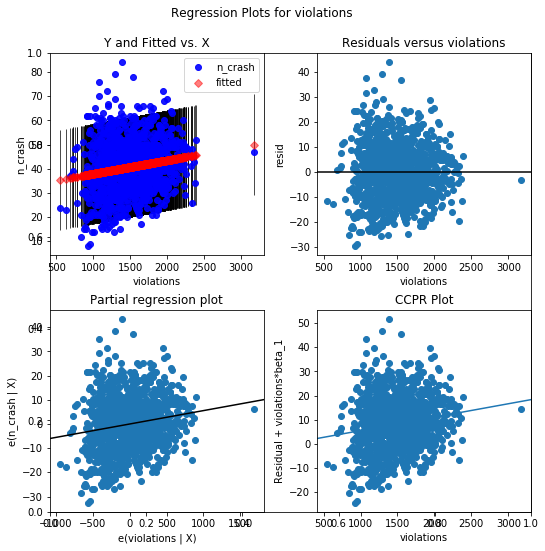

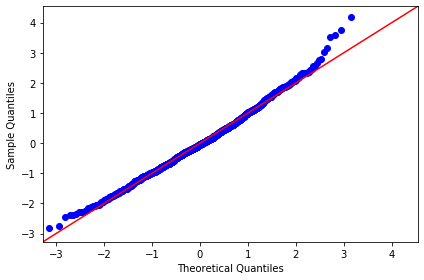




****************************************************************************************************
*                                     AFTERNOON_RUSH_CONGESTION                                    *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     94.81
Date:                Tue, 02 Mar 2021   Prob (F-statistic):           1.31e-21
Time:                        12:08:37   Log-Likelihood:                -4463.8
No. Observations:                1192   AIC:                             8932.
Df Residuals:                    1190   BIC:                             89

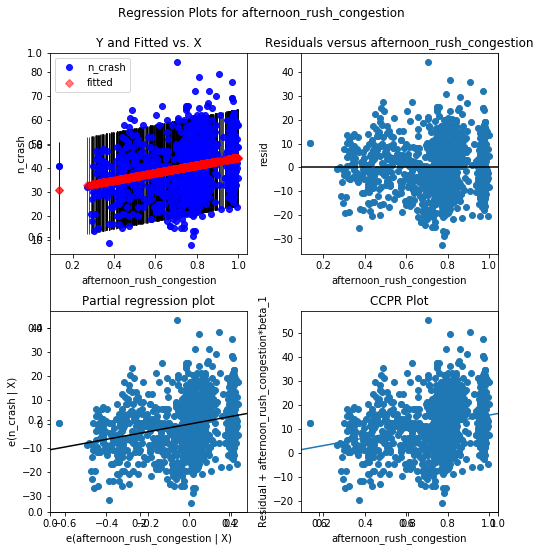

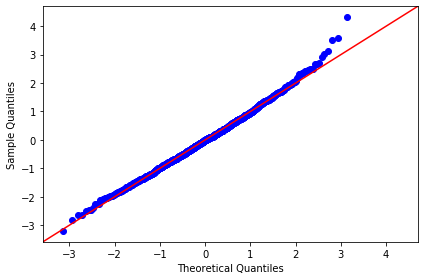




****************************************************************************************************
*                                               TEMP                                               *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     6.785
Date:                Tue, 02 Mar 2021   Prob (F-statistic):            0.00931
Time:                        12:08:39   Log-Likelihood:                -4601.4
No. Observations:                1217   AIC:                             9207.
Df Residuals:                    1215   BIC:                             92

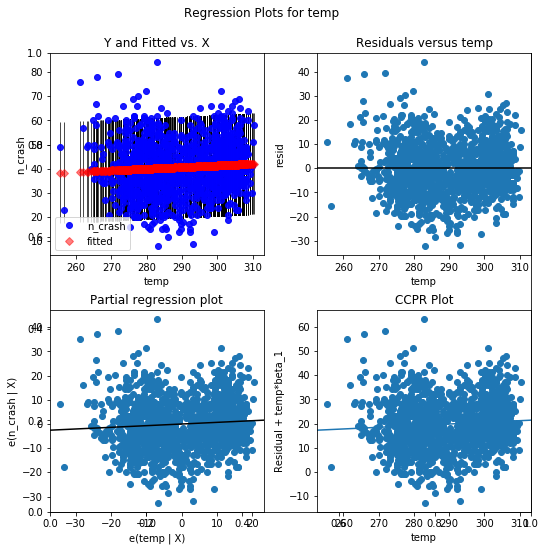

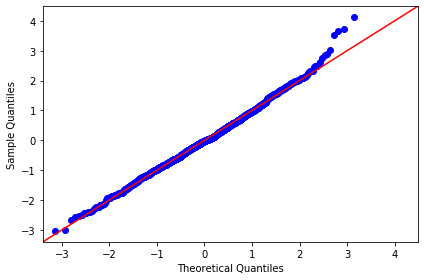




****************************************************************************************************
*                                              PRECIP                                              *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     8.650
Date:                Tue, 02 Mar 2021   Prob (F-statistic):            0.00333
Time:                        12:08:41   Log-Likelihood:                -4600.5
No. Observations:                1217   AIC:                             9205.
Df Residuals:                    1215   BIC:                             92

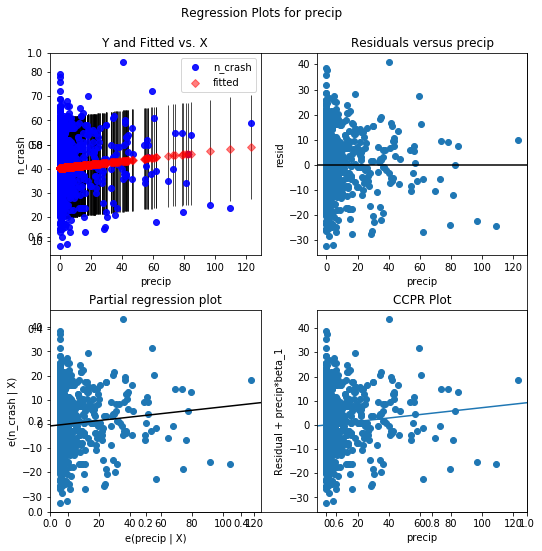

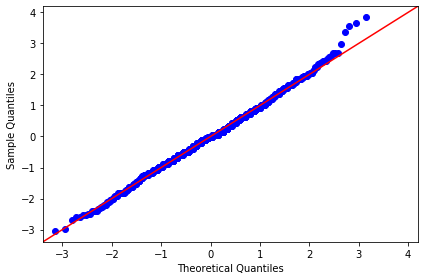




****************************************************************************************************
*                                              N_CAMS                                              *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     21.10
Date:                Tue, 02 Mar 2021   Prob (F-statistic):           4.82e-06
Time:                        12:08:42   Log-Likelihood:                -4594.3
No. Observations:                1217   AIC:                             9193.
Df Residuals:                    1215   BIC:                             92

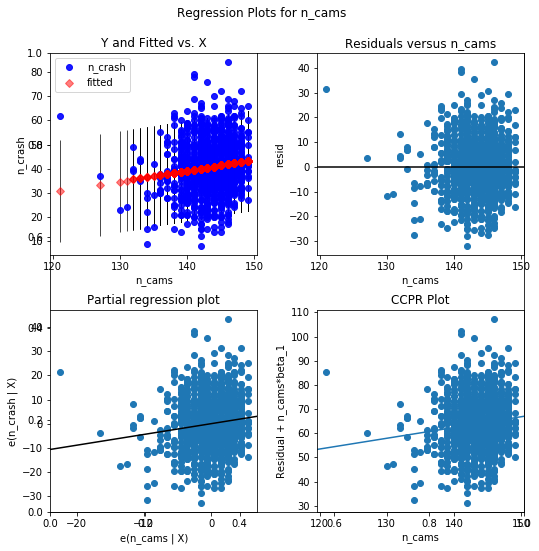

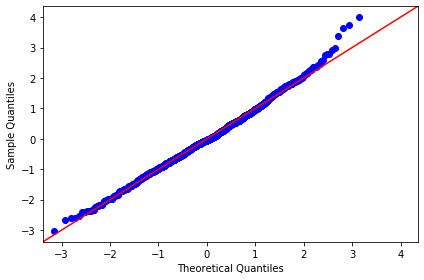




****************************************************************************************************
*                                              N_CRASH                                             *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.597e+32
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        12:08:44   Log-Likelihood:                 36837.
No. Observations:                1217   AIC:                        -7.367e+04
Df Residuals:                    1215   BIC:                        -7.366e

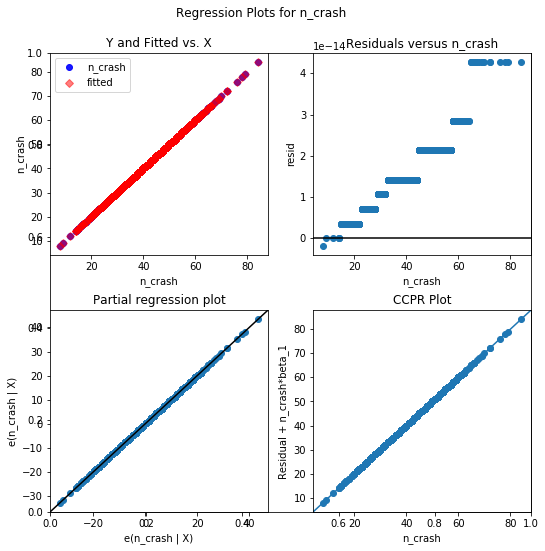

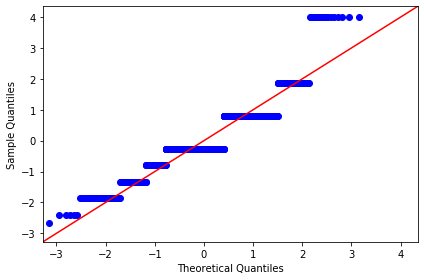

,ind_var,r_squared,intercept,slope,p-value,normality (JB)
2,temp,0.005553,2.085901e+01,0.068422,9.307105e-03,16.812192
3,precip,0.007069,4.033394e+01,0.071167,3.332039e-03,9.288553
4,n_cams,0.017067,-2.325657e+01,0.445547,4.822002e-06,16.419391
0,violations,0.029327,3.242218e+01,0.005549,1.827018e-09,25.856675
1,afternoon_rush_congestion,0.073792,2.859021e+01,15.842694,1.309843e-21,15.848276
5,n_crash,1.000000,6.217249e-15,1.000000,0.000000e+00,545.354909


In [145]:
# Lets look at some regressions for all of my chosen columns
# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

# Eliminated and useful features
target = 'n_crash'
keepers = ['violations', 'afternoon_rush_congestion', 
           'weekday', 'temp', 'precip', 'n_cams', 'n_crash']

#drop_me.remove(target)
categoricals = ['weekday']

df_cont = crash_df.copy()
df_cont = df_cont[keepers]
df_cont.drop(columns=categoricals, inplace=True)



results = []

for idx, column in enumerate(df_cont.columns):
    
    print('\n'*2)
    print('*'*100)
    print('*' + (49-len(column)//2)*' ' + column.upper() + (49-len(column)//2 - len(column)%2)*' ' + '*')
    print('*'*100)

    print ("Red Light Camera - Regression Analysis and Diagnostics Violations")
    
    f = '{}~{}'.format(target, column)  # create my model formula
    model = smf.ols(formula=f, data=df_cont).fit()  # fit the model
    print(model.summary())
    
    fig, axes = plt.subplots(figsize=(8,8))
    fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    fig.tight_layout()
    plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

result_df = pd.DataFrame(results, columns=['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ])
result_df.sort_values(by='r_squared')

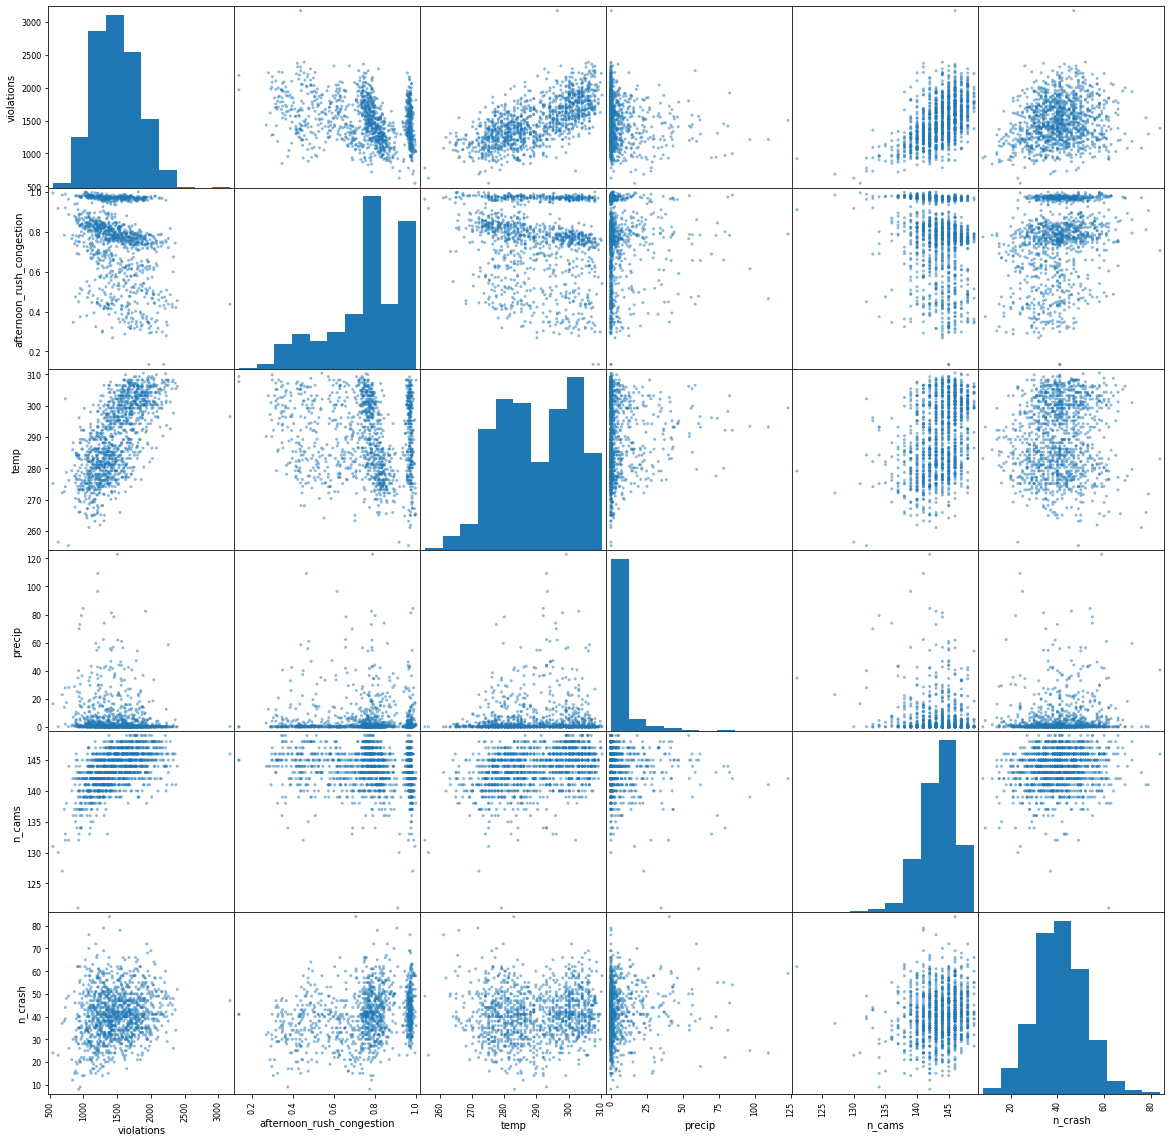

In [146]:
# scatter plot takes a few min

pd.plotting.scatter_matrix(df_cont,figsize  = [20, 20]);
plt.show()

In [147]:
df_cont.corr()  # create a correlation matrix

,violations,afternoon_rush_congestion,temp,precip,n_cams,n_crash
violations,1.000000,-0.318495,0.681941,-0.127594,0.543651,0.171250
afternoon_rush_congestion,-0.318495,1.000000,-0.140838,-0.036268,-0.163856,0.271647
temp,0.681941,-0.140838,1.000000,0.051028,0.367890,0.074519
precip,-0.127594,-0.036268,0.051028,1.000000,-0.104997,0.084079
n_cams,0.543651,-0.163856,0.367890,-0.104997,1.000000,0.130640
n_crash,0.171250,0.271647,0.074519,0.084079,0.130640,1.000000


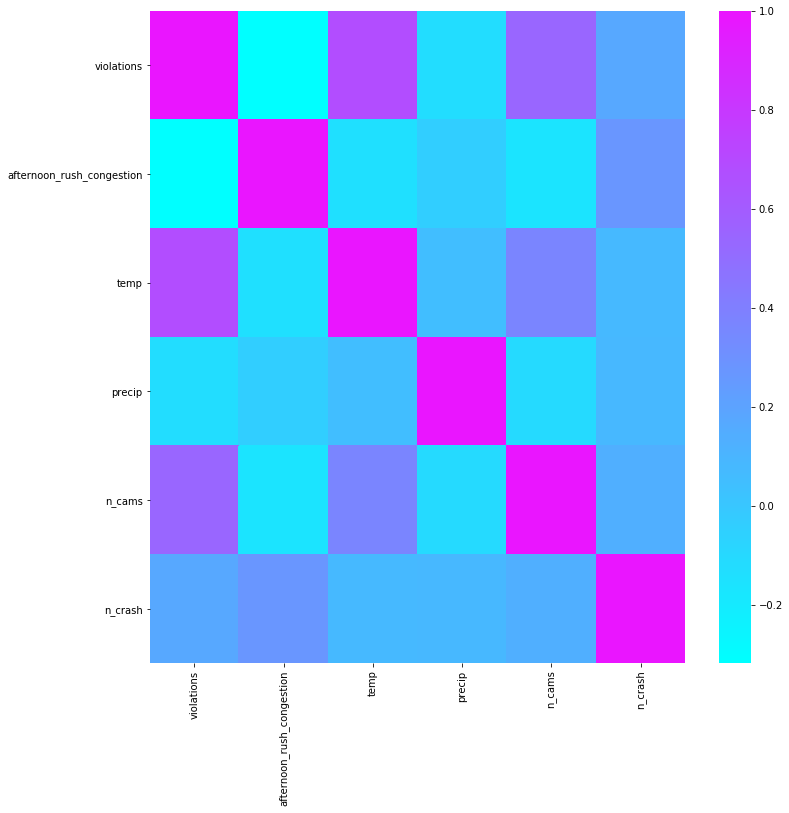

In [148]:
import seaborn as sns

plt.figure(figsize = (12,12))
sns.heatmap(df_cont.corr(), center=0.4, cmap = "cool");

# One Hot Encoding

In [149]:
# get rid of categories that have high correlation and others.
df_continuous = df_cont.copy()
df_ohe = crash_df.copy()[categoricals]

string_me = ['weekday']
df_ohe[string_me] = df_ohe[string_me].astype(str)

# One hot encoding   
df_ohe = pd.get_dummies(df_ohe, drop_first=True)
df_final = pd.concat([df_continuous, df_ohe], axis=1)

In [150]:
pd.options.display.max_columns = 100
df_final.head()

,violations,afternoon_rush_congestion,temp,precip,n_cams,n_crash,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,1704,0.947914,294.15,0.00,144,39,0,0,0,1,0,0
1,1623,0.777568,297.15,0.00,143,30,0,0,0,0,1,0
2,1494,0.573442,302.15,6.60,139,29,0,0,0,0,0,1
3,1258,0.579923,303.15,1.12,142,19,0,0,0,0,0,0
4,1366,0.963242,297.15,0.00,144,39,1,0,0,0,0,0


In [151]:
df_final.dropna(inplace=True)

### Test train split

In [159]:
X = df_final.drop(['n_crash'], axis=1)
y = df_final['n_crash']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [160]:
reg = LinearRegression()
reg.fit(X, y)  # my regression object

pred = reg.predict(X_test)

(0, 60)

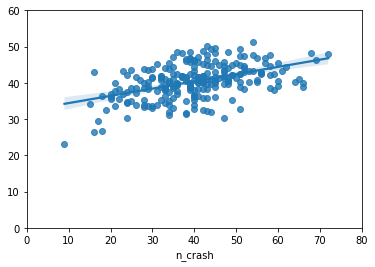

In [161]:
sns.regplot(y_test, pred)
plt.xlim(0,80)
plt.ylim(0,60)

### Plot residuals

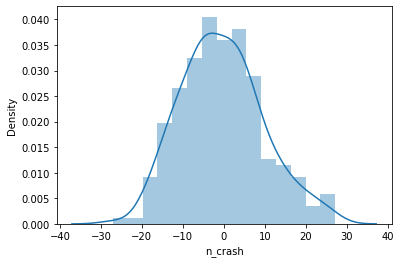

In [162]:
sns.distplot((y_test - pred), bins=15);

In [171]:
print('Mean crashes: {:.1f}'.format(y.mean()))
print('Standard Deviation: {:.1f}'.format(y.std()))
print()

test_pred = reg.predict(X_test)
train_pred = reg.predict(X_train)

print("Linear Regression Results:")
print('=========================')
print('Test set:')
print_evaluate(y_test, test_pred)

print()
print('Train set:')
print_evaluate(y_train, train_pred)

Mean crashes: 40.7
Standard Deviation: 10.6

Linear Regression Results:
Test set:
MAE: 8.04091907085129
MSE: 100.16807658491769
RMSE: 10.008400300993046
R2 Square 0.22099508956069502

Train set:
MAE: 7.322353295887497
MSE: 86.84529152691422
RMSE: 9.319082118262196
R2 Square 0.2037094107856754


In [172]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(reg, X_train, y_train)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,8.040919,100.168077,10.0084,0.220995,0.166228


In [165]:
coefficients = dict(zip(X.columns,list(reg.coef_)))
for var in coefficients:
    print('{:28}{}'.format(var, coefficients[var]))



violations                  0.009419848328550228
afternoon_rush_congestion   22.326162007728435
temp                        -0.0841930524626313
precip                      0.12565404601147293
n_cams                      0.23075253791365852
weekday_1                   1.4928425357621815
weekday_2                   0.4450685920612813
weekday_3                   1.0138237488301272
weekday_4                   4.7097220079525695
weekday_5                   4.645796315789466
weekday_6                   0.6948029525968042


## Try Ridge Regression
Would like to try this since we likely have collinearity in our dataset.

In [118]:
from sklearn.linear_model import Ridge, RidgeCV

model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100])
model.fit(X_train, y_train)
pred = model.predict(X_test)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print("Ridge Regression Results:")
print('=========================')
print('Test set:')
print_evaluate(y_test, test_pred)

print()
print('Train set:')
print_evaluate(y_train, train_pred)

Ridge Regression Results:
Test set:
MAE: 7.785814932087841
MSE: 94.0815848865008
RMSE: 9.699566221563767
R2 Square 0.15430243766729135

Train set:
MAE: 7.409210171934753
MSE: 89.10201733531767
RMSE: 9.439386491468483
R2 Square 0.2117180389641542


Ridge regression showed no improvement on original model.

In [119]:
ridge = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred) , cross_val(RidgeCV(), X_train, y_train)]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(ridge, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,7.594323,89.526786,9.461860,0.195245,0.187713
1,Ridge Regression,7.785815,94.081585,9.699566,0.154302,0.186658


In [120]:
#from sklearn.cross_validation import KFold



# Good time to do a baseline r_squared calculation
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(reg, X, y, scoring='r2', cv=crossvalidation))

# Do the actual regression
coefficients = dict(zip(X.columns,list(reg.coef_)))
for var in coefficients:
    print('{:>12}: {}'.format(var, coefficients[var]))

print('Baseline r_squared val:', baseline)

  violations: 0.009419848328550228
afternoon_rush_congestion: 22.326162007728435
        temp: -0.0841930524626313
      precip: 0.12565404601147293
      n_cams: 0.23075253791365852
   weekday_1: 1.4928425357621815
   weekday_2: 0.4450685920612813
   weekday_3: 1.0138237488301272
   weekday_4: 4.7097220079525695
   weekday_5: 4.645796315789466
   weekday_6: 0.6948029525968042
Baseline r_squared val: 0.18418221723432576


### Result

This model looked at around 50k intersection related crashes at traffic signals.  Data is aggragated for each day and 

A linear regression was chosen, so we could better make sense of the results and see the affect of each variable.

Crashes have a lot of noise in the data and are relatively infrequent events at intersections (the average Chicago intersection only has 0.4 accidents per month), so it isn't surprising to see this result. (3000 signaled intersections

Around 22% of the crashes could be explained by the model.  

Weekends (Sat/Sun) average about 4 additional accidents citywide over a typical weekday.
For every 8mm of rain/snow, we can expect an additional crash.

In the worst afternoon rush hour, you would expect 5 additional accidents.
In the best afternoon rush hour, you would expect 9 fewer accidents than average. 
(congestion is scaled from 0 to 1.  The max afternoon rush is 1, and the min is 0.13.  Mean is 0.76)

